In [11]:
import cv2
import keras
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.applications import EfficientNetV2B0
from keras.utils import Sequence
import numpy as np
from matplotlib import pyplot as plt
import math
from keras.preprocessing.image import ImageDataGenerator

In [12]:
data = pd.read_csv('../train.csv')
data_test =pd.read_csv('../test.csv')

data_list = []
for i in data['ID_img']:
    image = cv2.imread('../train/'+i)
    #print(image)
    image = cv2.resize(image, (224, 224))
    data_list.append(image)

data_list_test = []
for i in data_test['ID_img']:
    image = cv2.imread('../test/'+i)
    #print(image)
    image = cv2.resize(image, (224, 224))
    data_list_test.append(image)

In [13]:
'''def stratified_kfold(data,coef):
    test_index = []
    train_index = list(data.index)
    value_count = data['class'].value_counts()
    #print(value_count)
    for value in value_count.index:
        test_count = math.ceil(value_count[value]*coef)
        test_index += list(data[data['class'] == value].index[0:test_count])
    for index_test in test_index:
        train_index.remove(index_test)
    return train_index,test_index
'''
x_train = np.array(data_list).astype('float32') / 255.0
data['class'] = data['class'] - 1
y_train = data['class'].to_numpy().astype(int).reshape(-1, 1)
y_train = to_categorical(y_train)

x_test = np.array(data_list_test).astype('float32') / 255.0
data_test['class'] = data_test['class'] - 1
y_test = data_test['class'].to_numpy().astype(int).reshape(-1, 1)
y_test = to_categorical(y_test)


'''train_index,test_index = stratified_kfold(data,0.25)
x_train, x_val = x_train_full[train_index], x_train_full[test_index]
y_train, y_val = y_train_full[train_index], y_train_full[test_index]'''
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)


(6920, 102)
(6920, 224, 224, 3)
(918, 102)
(918, 224, 224, 3)


In [14]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
val_gen = DataGenerator(x_test, y_test, 4)
#train_gen = DataGenerator(x_train, y_train, 12)

datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range = 5,
    zoom_range = 0.1,
    channel_shift_range = 0.07,
    horizontal_flip=True,
    vertical_flip = True)
train_gen = datagen.flow(x_train, y_train, 4)

In [16]:
num_classes = 102
img_size = 224

inputs = layers.Input(shape=(img_size, img_size, 3))
output = EfficientNetV2B0(include_top=True, weights='weights_EffNetb0v2_ep30.h5', classes=num_classes,include_preprocessing = False, input_shape = (224,224,3))(inputs)#,include_preprocessing = False
model = keras.Model(inputs,output)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['top_k_categorical_accuracy'])
model.summary()
his = model.fit(train_gen,epochs=20,validation_data = val_gen)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 102)              6049974   
 al)                                                             
                                                                 
Total params: 6,049,974
Trainable params: 5,989,366
Non-trainable params: 60,608
_________________________________________________________________
Epoch 1/20
1730/1730 [==============================] - 165s 88ms/step - loss: 0.2277 - top_k_categorical_accuracy: 0.9926 - val_loss: 0.0798 - val_top_k_categorical_accuracy: 0.9989
Epoch 2/20
1730/1730 [==============================] - 143s 83ms/step - loss: 0.2137 - top_k_categorical_accuracy: 0.9949 - val_loss: 0.0657 - val_top_k_categorical_accuracy: 0.9989
Epoch 3/

In [17]:
model.layers[1].save_weights('EfficientNetb0v2_50.h5')

In [18]:
model.save('weights_EfficientNetb0v2_50.h5')

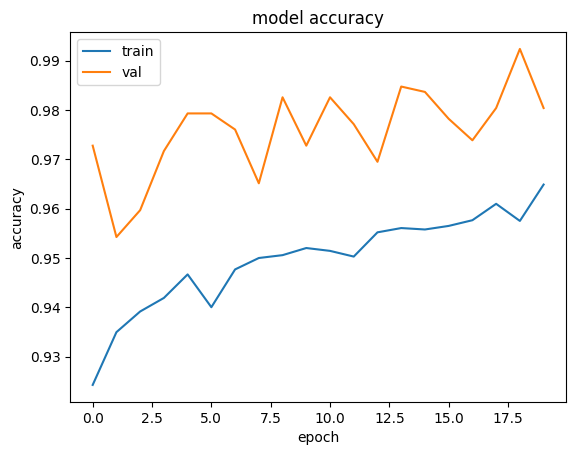

In [8]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()